In [ ]:
import re
import ast
import time  # sleep
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from konlpy.tag import Okt
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

plt.rcParams['font.family'] = 'AppleGothic'

In [ ]:
def extract(keywords: List[str]) -> pd.DataFrame:
    driver = webdriver.Chrome()
    data = []

    for keyword in keywords:
        driver.get("http://www.naver.com")
        elem = driver.find_element(By.ID, "query")
        elem.send_keys(f"{keyword}_오너평가")
        elem.send_keys(Keys.RETURN)
        time.sleep(4)

        # check counts to repeatedly scroll
        count_value = driver.find_element(By.CLASS_NAME, "_count").text
        element = driver.find_element(
            By.XPATH, '//*[@id="main_pack"]/div[3]/div[2]/div/div/div[5]'
        )

        # focus to specific element
        actions = ActionChains(driver)
        actions.move_to_element(element).perform()

        # javascript scroll script
        scroll_script = """
            var element = arguments[0];
            var deltaY = arguments[1];
            element
            element.scrollTop += deltaY;
        """
        
        # scroll down repeatedly to load more reviews
        for _ in range(int(count_value)//10+2):
            driver.execute_script(scroll_script, element, 2700)
            time.sleep(0.5)

        time.sleep(3)
        reviews = driver.find_elements(By.CLASS_NAME, 'u_cbox_comment_box')
        
        for review in reviews:
            # extract
            try:
                rate = review.find_element(
                    By.CLASS_NAME, 'u_cbox_info').text.replace("\n", " ")
                each_count_rates = review.find_element(
                    By.CLASS_NAME, 'u_cbox_multirating_eachcount').text.replace("\n", " ")
                comments = review.find_element(
                    By.CLASS_NAME, 'u_cbox_text_wrap').text.replace("\n", " ")
                recomm_sets = review.find_element(
                    By.CLASS_NAME, 'u_cbox_recomm_set').text.replace("\n", " ")
                data.append([keyword, rate, each_count_rates, comments, recomm_sets])
            except:
                print(review.text)
    df = pd.DataFrame(data, columns=["차종", "평점 평균", "기능 점수", "리뷰", "공감"])
    return df

In [ ]:
def extract_functional_points(line: str) -> dict:
    line = line.split(" ")
    data = dict()
    for ch in line[2:]:
        text, num = "", ""
        if ch[-2:] == '10':
            text, num = ch[:-2], int(ch[-2:])
        else:
            text, num = ch[:-1], int(ch[-1])
        data[text] = num
    return data

In [ ]:
def preprocess_text(text: str) -> str:
    # 텍스트 전처리
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    
    # 불용어 제거
    okt = Okt()
    tokens = okt.pos(text, norm=True, stem=True)
    words = [word for word, pos in tokens if pos in ['Noun', 'Verb', 'Adjective']]
    
    stopwords = set([
        '은', '는', '이', '가', '를', '에', '의', '도', '다', '한', '하', "타다",
        '있다', '들다', '하다', '없다', '되다', "포터", "아반떼", "소나타", "투싼", 
        "팰리세이드", "그랜저", "아이오닉6", "아이오닉", "이다", "같다", 
    ])
    words = [word for word in words if word not in stopwords]
    print(words)
    return words

In [ ]:
def extract_recomm_unrecomm(line: str) -> dict:
    line = line.split(" ")
    data = dict()
    for i in range(1, len(line)):
        if line[i] == "공감":
            data[line[i]] = int(line[i+1])
        elif line[i] == "비공감":
            data[line[i]] = int(line[i+1])
    return data

In [ ]:
def transform(df: pd.DataFrame):
    # 평점 평균
    df['평점 평균'] = df['평점 평균'].apply(lambda x: float(x.split(" ")[-1]))
    
    # 기능 점수 => 각 항목으로 분리
    df['기능 점수'] = df['기능 점수'].apply(extract_functional_points)
    for key in df['기능 점수'][0].keys():
        df[key] = df['기능 점수'].apply(lambda x: x.get(key, 0))
    
    # 리뷰
    df['리뷰'] = df['리뷰'].apply(preprocess_text)
    
    # 공감
    df['공감/비공감'] = df['공감'].apply(extract_recomm_unrecomm)
    for key in df['공감/비공감'][0].keys():
        df[key] = df['공감/비공감'].apply(lambda x: x.get(key, 0))
    df.drop(['기능 점수', '공감/비공감'], axis=1, inplace=True)

    return df

In [ ]:
# 긍정/부정 분할
def split_pos_neg_by_spec_col(
    boundary: float,
    df: pd.DataFrame, 
) -> pd.DataFrame: 
    pos_df = df[df["평점 평균"] >= boundary]
    neg_df = df[df["평점 평균"] < boundary]
    return pos_df, neg_df

In [ ]:
# 워드 클라우드 생성
def analysis(
    texts: List[str],
    title: str,
    ax: plt.Axes
) -> plt.Axes:
    wc = WordCloud(
        font_path='/Library/Fonts/AppleGothic.ttf',
        background_color='white',
        width=800, 
        height=800,
        max_words=200,
        collocations=False
    ).generate(" ".join(texts))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)
    ax.figure.tight_layout()
    return ax

In [ ]:
def visualize_with_axes(
    posi_texts: list[str],
    nega_texts: list[str],
    posi_title: str,
    nega_title: str
):
    fig, axes = plt.subplots(2, 1, figsize=(15, 15))
    analysis(posi_texts, posi_title, axes[0])
    analysis(nega_texts, nega_title, axes[1])
    
    plt.tight_layout()
    plt.show()  

### Extract

In [ ]:
extract_df = extract(["아반떼", "소나타", "팰리세이드", "포터2", "그랜저", "아이오닉6"])

### Transform

In [ ]:
extract_df.to_csv("extract_df.csv", index=False)

In [ ]:
transformed_df = transform(extract_df)

### Load

In [ ]:
transformed_df.to_csv('transformed.csv', index=False)

### Analysis

In [ ]:
transformed_df = pd.read_csv('transformed.csv')

In [ ]:
pos, neg = split_pos_neg_by_spec_col(4.0, transformed_df)
pos_texts = pos['리뷰'].apply(ast.literal_eval).sum()
neg_texts = neg['리뷰'].apply(ast.literal_eval).sum()

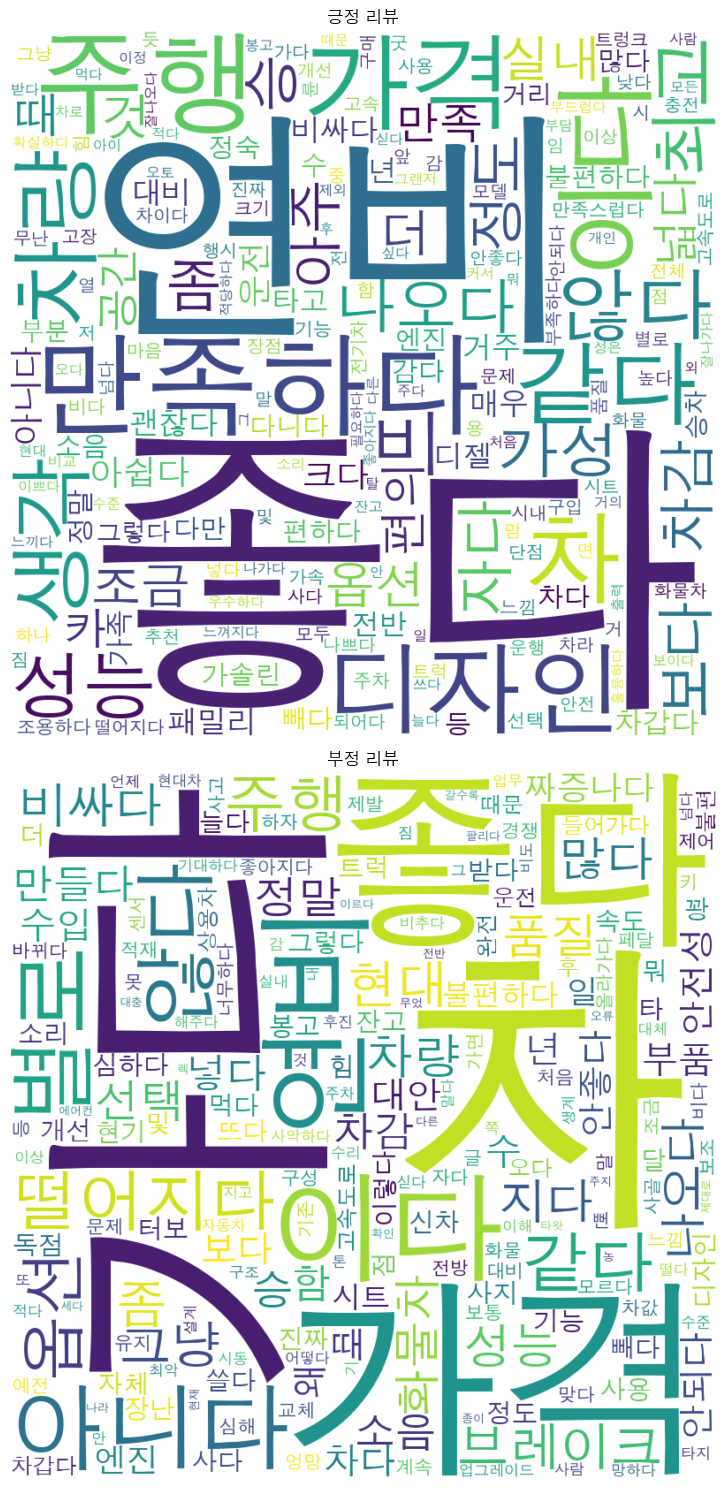

In [17]:
visualize_with_axes(pos_texts, neg_texts, '긍정 리뷰', '부정 리뷰')